# Introduction
This note illustrates an approach to fitting the parameters of a bond
graph model to experimental data. Insofar as the parameters are
associated with a bond graph, they are *physically-plausible*
<cite data-cite="GawCudCra20"></cite>.

    
The approach uses a bond-graph derived from a stoichiometric model of *e.coli*
<cite data-cite="OrtFlePal10"></cite>
(using a method described elsewhere <cite data-cite="Gaw20X"></cite>)
combined with experimental values of *reaction potential*, *reaction flux* and *species concentration* from the literature <cite data-cite="ParRubXu16"></cite>.


## Setup modules

In [1]:
## Paths
NeedPath=False
if NeedPath:
    import sys
    sys.path += ['/usr/lib/python3/dist-packages']
    
    

In [2]:
## Maths library
import numpy as np
import scipy

## BG tools
import BondGraphTools as bgt

## SVG bond graph
import svgBondGraph as sbg

## BG stoichiometric utilities
import stoich as st

## Modular bond graphs
import modularBondGraph as mbg

## Stoichiometric conversion
import CobraExtract as Extract
import stoichBondGraph as stbg

## Potentials
import phiData

## Faraday constant
import scipy.constants as con
F = con.physical_constants['Faraday constant'][0]

## Display
import IPython.display as disp

## Plotting
import matplotlib.pyplot as plt


import copy

## Allow output from within functions
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import importlib as imp

quiet = True
SaveFig = False
showMu=True

## Quadratic programming QP.
\begin{align}
\text{minimise } & \frac{1}{2}x^TPx + q^Tx\\
\text{subject to } & Gx \le h\\
\text{and } & Ax = b
\end{align}

In the case considered here, there is no equality constraint and
\begin{align}
x &= \hat{\phi}\\
P & = N N^T + \mu I_{n_X \times n_X}\\
q &= (N \Phi)^T \\
G &= N^T\\
h &= -\Phi_{min}
\end{align}

$\mu > 0$ is required to give a convex QP: in essence it turns a non-unique solution for $\phi$ into a minimum norm solution.

In [3]:
## Quadratic programming stuff.
import quadprog

## Function from https://scaron.info/blog/quadratic-programming-in-python.html
def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        if G is None:
            qp_C = None
            qp_b = None
        else:
            qp_C = -G.T
            qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

## Function to compute phi from Phi subject to Phi>positive number
## NN Reduced N corresponding to known Phi
def quadsolve_phi(N0,N1,Phi0,Phi_min=0.0,mu=1e-10):
    
    (n_X,n_V) = N1.shape
    P = 1.0*N0@(N0.T) + mu*np.eye(n_X)
    q = (N0@Phi0).T
    G = 1.0*N1.T
    h = -Phi_min*np.ones((n_V))
    phi = quadprog_solve_qp(P, q, G=G, h=h)
    
    return phi


# Conversion factor

In [4]:
Factor = st.F()/1e6
print(f'To convert from kJ/mol to mV, divide by {1/Factor:4.3}')

To convert from kJ/mol to mV, divide by 10.4


# Extract Model
This example uses the Glycolysis and Pentose Phosphate pathways.

Notes:

- Reactions RPI, PGK and PGM are reversed to correspond to positive flows.
- The resultant stoichiometric matrix $N$ relates reaction flows ($f$) to species flows ($\dot{x}$): 

\begin{equation}
\dot{x} = N f
\end{equation}

## Extract stoichiometry

In [5]:
sm = Extract.extract(cobraname='textbook',Remove=['_C','__' ],
negReaction=['RPI','PGK','PGM'], quiet=quiet)


Extracting stoichiometric matrix from: textbook
Cobra Model name: e_coli_core BondGraphTools name: e_coli_core_abg
Extract.Integer only handles one non-integer per reaction
Multiplying reaction BIOMASS_ECOLIORE ( 12 ) by 0.6684491978609626 to avoid non-integer species 3PG ( 2 )
Multiplying reaction CYTBD ( 15 ) by 2.0 to avoid non-integer species O2 ( 55 )
Multiplying reaction PGK ( 54 ) by -1
Multiplying reaction PGM ( 56 ) by -1
Multiplying reaction RPI ( 65 ) by -1


In [6]:
name = 'GlyPPP_abg'
reaction = []

## Glycolysis
reaction += ['PGI','PFK','FBA','TPI']

## Pentose Phosphate
reaction += ['G6PDH2R','PGL','GND','RPI','TKT2','TALA','TKT1','RPE']

ss = Extract.choose(sm,reaction=reaction)

## Create BG
ss['name'] = name
stbg.model(ss)
import GlyPPP_abg
imp.reload(GlyPPP_abg)
s = st.stoich(GlyPPP_abg.model(),quiet=quiet)

<module 'GlyPPP_abg' from '/home/peterg/WORK/Research/SystemsBiology/Notes/2021/Parameter/GlyPPP_abg.py'>

In [7]:

## Set up chemostats
chemostats = ['ADP','ATP','H','H2O','NADP','NADPH','CO2']
chemostats += ['G6P','G3P','R5P']
#chemostats += ['G6P','R5P']
chemostats.sort()
print(chemostats)
sc = st.statify(s,chemostats=chemostats)

sp = st.path(s,sc,pathname='PPP')
print(st.sprintp(sc))
disp.Latex(st.sprintrl(sp,chemformula=True))


['ADP', 'ATP', 'CO2', 'G3P', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']
3 pathways
0:  + PGI + PFK + FBA + TPI
1:  + G6PDH2R + PGL + GND + RPI
2:  - 2 PGI + 2 G6PDH2R + 2 PGL + 2 GND + TKT2 + TALA + TKT1 + 2 RPE



<IPython.core.display.Latex object>

In [8]:
print(st.sprintl(sc,'K',transpose=True))
disp.Latex(st.sprintl(sc,'K',transpose=True))

\begin{align}
K^T &=
\left(\begin{array}{cccccccccccc}1 & 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 1 & 1 & 1 & 1 & 0 & 0 & 0 & 0\\-2 & 0 & 0 & 0 & 2 & 2 & 2 & 0 & 1 & 1 & 1 & 2\end{array}\right)
\end{align}



<IPython.core.display.Latex object>

## Extract reaction potentials $\Phi$ and deduce plausible species potentials $\phi$.

Because of the energetic constaints implied by the bond graph, the reaction potentials $\Phi$ are 
related to the species potentials $\phi$ by
\begin{equation}
\Phi = - N^T \phi
\end{equation}
Typically, there are more species than reactions and so $N$ has more rows than columns.
Given the reaction potentials $\Phi$, the species potentials can be estimated using
the *pseudo inverse* $N^\dagger$ of $-N^T$:
\begin{equation}
\hat{\phi} = N^\dagger \Phi
\end{equation}

Notes:

- In general $\hat{\phi} \ne \phi$ but is physically plausible insofar as $-N^T \hat{\phi}=\Phi$.

In [9]:
def getPhi(s,Phi_hyd=0.5,phi_6PGL=None,quadprog=False):
    """Extract phi for given system using
    Reaction potentials from ParRubXu16"""
    
    ## Reaction potentials from ParRubXu16
    PHI = phiData.Phi_ParRubXu16_Measured()
    
#     Phenotype = 'Mammalian'
#     Phenotype = 'Yeast'
    Phenotype = 'Ecoli'
    Phi_reac = PHI[Phenotype]
    
    Phi = np.zeros((len(s['reaction']),1))
    N = copy.copy(s['N'])
    N_0 = None
    N_1 = None
    Phi_0 = []
    for j,reac in enumerate(s['reaction']):
        if (reac in Phi_reac.keys()) and not np.isnan(Phi_reac[reac]):
            Phi_0.append(Phi_reac[reac])
            if N_0 is None:
                N_0 = N[:,j]
            else:
                N_0 = np.vstack((N_0,N[:,j]))
        else:
            if N_1 is None:
                N_1 = N[:,j]
            else:
                N_1 = np.vstack((N_1,N[:,j]))

    Phi_0 = np.array(Phi_0)
    #print(N_1)
    
    ## Compute Phi
    N_0 = N_0.T
    N_1 = N_1.T
    
    n_X,n_V = N_0.shape
    print(f'Extracting {n_X} values of phi from {n_V} values of Phi')

    
    if quadprog:
        phi = quadsolve_phi(N_0,N_1,Phi_0,Phi_min=1e-3,mu=1e-10)
    else:
        ## Compute Phi using pseudo inverse
        pinvNT =  scipy.linalg.pinv(N_0.T)
        phi = -pinvNT@Phi_0
        
    if phi_6PGL is not None:
        ## Reset 6PGL
        i_6PGL = s['species'].index('6PGL')
        phi[i_6PGL] = phi_6PGL
        print (f'Resetting phi_6GPL to {int(1e3*phi[i_6PGL])} mV' )

    ## Sanity check
    Phi_new = -N_0.T@phi
    err = np.linalg.norm(Phi_new-Phi_0)
    print(f'Phi error = {int(err*1000)}mV\n')
    
    Phi = -N.T@phi
    
    return Phi,phi,Phi_0,Phi_reac
     

In [10]:
Phi_,phi_est_,Phi_0_,Phi_reac_ = getPhi(s,quadprog=False)
print('Minimum Phi = ', int(round(np.min(1e3*Phi_))), 'mV')

Extracting 19 values of phi from 10 values of Phi
Phi error = 0mV

Minimum Phi =  -3 mV


In [11]:
Phi,phi_est,Phi_0,Phi_reac = getPhi(s,quadprog=True)
print('Minimum Phi = ', int(round(np.min(1e3*Phi))), 'mV')

print('\nChange in phi')
for i,spec in enumerate(s['species']):
    change = int(1e3*(phi_est[i]-phi_est_[i]))
    if not change==0:
        print(f'{i} {spec}\t {change}')
    
print('\nChange in Phi')
for i,reac in enumerate(s['reaction']):
    change = int(round(1e3*(Phi[i]-Phi_[i])))
    if not change == 0:
        print(f'{i} {reac}\t {change} {int(round(1e3*Phi[i]))} {int(round(1e3*Phi_[i]))}')
        

Extracting 19 values of phi from 10 values of Phi
Phi error = 0mV

Minimum Phi =  0 mV

Change in phi
1 6PGL	 1
12 H2O	 1

Change in Phi
5 PGL	 4 1 -3


## Extracted reactions and reaction potentials

In [12]:
disp.Latex(st.sprintrl(s,chemformula=True,Phi=Phi,units=['mV','kJ'] ,showMu=showMu))

<IPython.core.display.Latex object>

# Deduce Pathway Flows

From basic stoichiometric analysis, steady-state flows can be written as:
\begin{align}
f &= K_p f_p\\
\text{where }
K_p N^{cd} &= 0
\end{align}
Note that the *pathway matrix* $K_p$ is dependent on the choice of chemostats.

Given a set of experimental flows $f$, an estimate $\hat{f}_p$ of $f_p$ can be obtained from the *least-squares* formula:
\begin{equation}
(K_p^T K_p) \hat{f}_p = K_p^T f
\end{equation}

Notes:

- $v_p$ is a $n_p$ vector containg the pathways flows
- $(K_p^T K_p)$ is a square $n_p \times n_p$ matrix where $n_p$ is the number of pathways
- If some flows are not measured, the corresponding rows of $K_p$ are deleted
- the reaction flows (including the missing ones) can be estimated from $\hat{f} = K_p \hat{f}_p$.
- the estimated chemostat flows are given by the non-zero elements of
\begin{equation}
\hat{\dot{x}} = N \hat{f}
\end{equation}

In [13]:
def PathwayFlux(K,reaction,Reaction,flux):
    
    #KK = st.singleRemove(K)
    KK = K
    Kp = None
    Flux = {}
    reac_known = []
    #flux = phiData.ParRubXu16_flux()
    for i,reac in enumerate(reaction):
        if reac in flux.keys():
            reac_known.append(reac)
            fi = flux[reac]
            #Ki = np.abs(KK[i,:])
            Ki = KK[i,:]
            #print(reac,Ki)
            if Kp is None:
                Kp = Ki
                f = fi
            else:
                Kp = np.vstack((Kp,Ki))
                f = np.vstack((f,fi))
    #print(Kp)

    if Kp is not None:    
        #print(f)
        f_p = np.linalg.solve(Kp.T@Kp,Kp.T@f)
        for i,Reac in enumerate(Reaction):
            Flux[Reac] = f_p[i][0]
        #print(f_p)
        f_est = Kp@f_p
        #print(Kp@f_p-f)
        
    error = np.linalg.norm(f_est-f)/len(f)
    print(f'Flux error = {error:.2e}')
    
    return Flux,f_p,f_est,f,reac_known
    

# Reaction constants (modified mass-action) and Michaelis-Menten

The modified mass-action formula is <cite data-cite="GawCudCra20"></cite>:
\begin{align}
  f &= \kappa \left ( \exp \frac{\Phi^f}{\alpha V_N} - \exp
      \frac{\Phi^r}{\alpha V_N} \right )\label{eq:MMA0}
\end{align}
Thus an estimate for $\kappa$ can be computed as:
\begin{align}
\hat{\kappa} &= \frac{\hat{f}}{f_0}\\
\text{where }
f_0 &= \left ( \exp \frac{\Phi^f}{\alpha V_N} - \exp
      \frac{\Phi^r}{\alpha V_N} \right )
\end{align}

In [14]:
def reactionConstant(s,phi_est,f_est,alpha=1,K_E=100,K_C=1,rho=0.9):
    
    V_N = st.V_N()
    
    ## Extract stoichiometry
    N = s['N']
    Nf = s['Nf']
    Nr = s['Nr']
    reaction = s['reaction']
    
    ## Compute Phis from estimated phi 
    Phi_ = -N.T@phi_est
    Phi_f = Nf.T@phi_est 
    Phi_r = Nr.T@phi_est

    ## Compute normalised flow rates
    
    f_plus  = np.exp(Phi_f/(alpha*V_N)) 
    f_minus = np.exp(Phi_r/(alpha*V_N))
    f0 = f_plus - f_minus
  
    
    parameter = {}
    MMparameter = {}
    for i,react in enumerate(reaction):
        MMpar = {}
        kap = f_est[i][0]/f0[i]
        parameter[f'kappa_{react}'] = kap
        #print(f'{react}: \tPhi = {int(Phi_[i]*1000)}mV, \tf_est = {f_est[i][0]:.2e}, \tkappa = {kap:.2}')
        
        ## MM version
        X_data = np.array([1,f_est[i][0],-f_est[i][0]/f0[i]])
        Y_data = f_est[i][0]*f_plus[i]/f0[i]
#         print(X_data)
#         print(Y_data)
        
        XTX = np.outer(X_data,X_data)
        XTy = X_data*Y_data

#         print('XTX:', XTX)
#         print('XTy:', XTy)
        
        ## Pseuso inverse eapproach
#         theta = np.linalg.pinv(XTX)@XTy
#         print(theta)
        
        ## QP approach
#         f_max_est = 10
        rho_est = rho
        k_v_est = K_C/K_E
        
        G = -np.eye(3)
        h = -0*np.ones(3)
        A_eq = np.array([[0,1,0],[0,0,1]])
        b_eq = np.array([rho_est,k_v_est])
        
#         A_eq = np.array([[1,0,0],[0,1,0]])
#         b_eq = np.array([f_max_est,rho_est])
        
        
        theta = quadprog_solve_qp(XTX+1e-10*np.eye(3),-XTy,G,h,A_eq,b_eq)
        f_max = theta[0]
        rho = theta[1]
        k_v = theta[2]
        kappa = f_max/k_v
        
        MMpar['f_max'] = theta[0]
        MMpar['rho'] = theta[1]
        MMpar['k_v'] = theta[2]
#         print(f'{react}: kappa={kappa:6.2f} f_max={f_max:.2} rho={rho:0.2f} k_v={k_v:6.2f}')
        
        MMparameter[react] = MMpar

    return parameter,MMparameter

In [15]:
## Convert to BG parameters
def MMtoBG(MMpar,K_E=100):
    kappa = np.zeros(2)
    K_CE = np.zeros(2)
    rho = MMpar['rho']
    K_C = K_E*MMpar['k_v']
#     print(MMpar)
    kappa_bar = MMpar['f_max']/K_C
    kappa[0] = kappa_bar/rho
    kappa[1] = kappa_bar/(1-rho)
    
    K_CE[0] = K_C
    K_CE[1] = K_E
#     print(kappa_1,kappa_2,K_E)
    
    return kappa,K_CE
    


## Normalise data

In [16]:
imp.reload(phiData)
## Extract experimetal data
Concentration = phiData.ParRubXu16_conc() # M
concentration = Concentration['Ecoli']

Flux = phiData.ParRubXu16_flux() # mM/min
flux = Flux['Ecoli']

c_0 = concentration['G6P']
f_0 = flux['PGI']/60
t_0 = (1e3*c_0)/f_0

print(f'c_0 = {c_0*1000} mM, f_0 = {f_0} mM/sec, t_0 = {t_0} sec')

<module 'phiData' from '/home/peterg/WORK/Research/SystemsBiology/lib/python/phiData.py'>

c_0 = 7.88 mM, f_0 = 0.9916666666666667 mM/sec, t_0 = 7.946218487394957 sec


## Show computed reaction flows

In [17]:
K = sc['K']
n_path = K.shape[1]
Reaction = []
for i in range(n_path):
    Reaction += [f'PPP{i+1}']
    
    print(Reaction)

for reac in flux.keys():
    flux[reac] *= 1/f_0

fluxp,f_p,f_est,f,reaction = PathwayFlux(sc['K'],s['reaction'],Reaction,flux)

## Assumed values:
K_E = 10
K_C = 1
rho = 0.2


## Reaction constants
f_est = sc['K']@f_p
parameter,MMparameter = reactionConstant(s,phi_est,f_est,K_E=K_E,K_C=K_C,rho=rho)
K_C=K_C
#f_est = sc['K']@f_p
j=0

print('\n\n%% LaTeX table')
print('\\hline')
print('Reaction &\t $\Phi$~mV &\t $\hat{\Phi}$~mV &\t $f$ & $\\hat{f}$ \
& $\\hat{\\kappa}$ & $\\hat{\\kappa_1}$ & $\\hat{\\kappa_2}$\\\\')
print('\\hline') 
for i,reac in enumerate(s['reaction']):

    ## BG MM equivalent
    MMpar = MMparameter[reac]
    kappa_MM,K_CE = MMtoBG(MMpar,K_E=100.0)

    if reac in flux.keys():
        ff = f'{f[j][0]:0.2f}'
        j += 1
    else:
        ff = '--'
    if reac in Phi_reac.keys():
        PP = f'{1e3*Phi_reac[reac]:.2f}'
    else:
        PP = '--'
    kappa = 'kappa_'+reac
    print(
        f'{reac} &\t {PP} &\t {1e3*Phi[i]:.2f} &\t {ff} & {f_est[i][0]:0.2f} \
        & {parameter[kappa]:.2f} & {kappa_MM[0]:.2f} & {kappa_MM[1]:.2f} \\\\'
    )
print('\\hline')

['PPP1']
['PPP1', 'PPP2']
['PPP1', 'PPP2', 'PPP3']
Flux error = 1.86e-01


%% LaTeX table
\hline
Reaction &	 $\Phi$~mV &	 $\hat{\Phi}$~mV &	 $f$ & $\hat{f}$ & $\hat{\kappa}$ & $\hat{\kappa_1}$ & $\hat{\kappa_2}$\\
\hline
PGI &	 16.48 &	 16.48 &	 60.00 & 59.52         & 154.39 & 66.44 & 16.61 \\
PFK &	 68.82 &	 68.82 &	 62.62 & 63.12         & 54.85 & 30.59 & 7.65 \\
FBA &	 20.00 &	 20.00 &	 63.43 & 63.12         & 160.08 & 61.59 & 15.40 \\
TPI &	 7.98 &	 7.98 &	 62.82 & 63.12         & 353.93 & 133.64 & 33.41 \\
G6PDH2R &	 -- &	 82.84 &	 -- & 11.58         & 4.67 & 5.14 & 1.28 \\
PGL &	 -- &	 1.00 &	 -- & 11.58         & 291.64 & 171.06 & 42.77 \\
GND &	 114.53 &	 114.53 &	 11.70 & 11.58         & 1.27 & 4.78 & 1.19 \\
RPI &	 0.04 &	 0.04 &	 7.87 & 7.98         & 4206.98 & 2785.35 & 696.34 \\
TKT2 &	 16.38 &	 16.38 &	 0.91 & 1.80         & 9.17 & 2.24 & 0.56 \\
TALA &	 54.41 &	 54.41 &	 -- & 1.80         & 1.66 & 0.94 & 0.23 \\
TKT1 &	 4.04 &	 4.04 &	 2.92 & 1.80         & 8.82 & 6.66 

## Show computed chemostat flows

In [18]:
dx_est = s['N']@f_est

print('\n\n%% LaTeX table')
print('\\hline')
print('Chemostat &\t flow \\\\')
print('\\hline')
for i,spec in enumerate(s['species']):
    if spec in chemostats:
        print(f'{spec} &\t {dx_est[i][0]:0.2f} \\\\')
print('\\hline')



%% LaTeX table
\hline
Chemostat &	 flow \\
\hline
ADP &	 63.12 \\
ATP &	 -63.12 \\
CO2 &	 11.58 \\
G3P &	 128.03 \\
G6P &	 -71.10 \\
H &	 86.27 \\
H2O &	 -11.58 \\
NADP &	 -23.16 \\
NADPH &	 23.16 \\
R5P &	 6.19 \\
\hline


## Show pathway flows

In [19]:
print('\n\n%% LaTeX table')
print('\\hline')
print('Pathway &\t $\hat{f}_p$ \\\\')
print('\\hline')
for reac in fluxp.keys():
    print(f'{reac} &\t {fluxp[reac]:0.2f} \\\\')
print('\\hline')



%% LaTeX table
\hline
Pathway &	 $\hat{f}_p$ \\
\hline
PPP1 &	 63.12 \\
PPP2 &	 7.98 \\
PPP3 &	 1.80 \\
\hline


# Species constants

\begin{equation}
K = \frac{\exp \phi}{x^\circ} = \frac{\exp \phi}{V c^\circ}
\end{equation}

In [20]:
#imp.reload(phiData)

print('\n\n%% LaTeX table')
print('\\hline')
print('Species &\t $\\hat{\\phi}~mV$ & $\\frac{c}{c_0}$ & $\\hat{K}$ \\\\')
print('\\hline')


#concentration['H'] = 1e-7

## Data in mM
scale = 1e3
K_spec = np.ones(s['n_X'])
conc = np.ones(s['n_X'])
c_G6P = concentration['G6P']
#print('c_G6P',c_G6P)
for i,spec in enumerate(s['species']):
    if spec in concentration.keys():  
        conc[i] = concentration[spec]/c_G6P
        K_spec[i] = np.exp(phi_est[i]/st.V_N())/conc[i] 
        print(f'{spec} & {int(round(1e3*phi_est[i]))} &  \t{conc[i]:.4f} & {K_spec[i]:.4f} \\\\')
    else:
        K_spec[i] = np.exp(phi_est[i]/st.V_N())
#         print(f'{spec} &{phi_est[i]:.2} & -- & --\\\\')
    
print('\\hline')

#print(conc)
print(s['species'])



%% LaTeX table
\hline
Species &	 $\hat{\phi}~mV$ & $\frac{c}{c_0}$ & $\hat{K}$ \\
\hline
6PGC & 29 &  	0.4784 & 6.2335 \\
ADP & -27 &  	0.0704 & 5.1546 \\
ATP & 27 &  	1.2221 & 2.2539 \\
CO2 & -30 &  	0.0095 & 33.7942 \\
DHAP & -10 &  	0.3883 & 1.7790 \\
E4P & -27 &  	0.0062 & 57.9353 \\
F6P & -21 &  	0.3198 & 1.4140 \\
FDP & -8 &  	1.9289 & 0.3880 \\
G3P & -18 &  	0.0344 & 14.9020 \\
G6P & -5 &  	1.0000 & 0.8377 \\
NADP & 30 &  	0.0003 & 11747.0633 \\
NADPH & -30 &  	0.0154 & 21.0027 \\
R5P & 5 &  	0.0999 & 12.2419 \\
RU5PD & 5 &  	0.0142 & 86.1551 \\
S7P & 24 &  	0.1119 & 21.7513 \\
XU5PD & 5 &  	0.0230 & 51.6829 \\
\hline
['6PGC', '6PGL', 'ADP', 'ATP', 'CO2', 'DHAP', 'E4P', 'F6P', 'FDP', 'G3P', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P', 'RU5PD', 'S7P', 'XU5PD']


# Simulation

## Set up parameters

- Reaction constants already set

In [21]:
for i,spec in enumerate(s['species']):
    #K_spec = np.exp(phi_est[i]/st.V_N())
    parameter['K_'+spec] = K_spec[i]

## Set up chemostats and flowstats

In [22]:
def setPath(s,path='R5P'):
    
    print('\n Path =', path)
    
    if path == 'R5P':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']
        flowstats =['G6PDH2R']
        dX_G6P = 5
    elif path == 'NADPH':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH']
        flowstats = []
        dX_G6P = 1
    elif path == 'both':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']
        flowstats =  ['PGI', 'TKT2']
        dX_G6P = 1
    elif path == 'all':
        chemostats = ['ADP', 'ATP', 'CO2', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P','G3P']
        flowstats = []
        dX_G6P = 10
        
    sc = st.statify(s,chemostats=chemostats)
    sf = st.statify(s,flowstats=flowstats)
    
    return sc,sf,dX_G6P


## Time unit

In [23]:
##t_0 = ((1000*c_G6P)/flux_PGI)*100
print(f"Time unit: {t_0:4.2f} sec")

Time unit: 7.95 sec


## Simulation


 Path = all


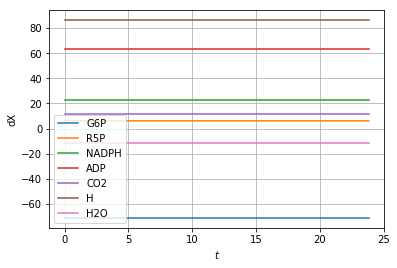

G6P:	-71.1 	-71.1	-10.0	-100.0%
R5P:	6.2 	6.2	0.9	8.7%
NADPH:	23.2 	23.2	3.3	32.6%
ADP:	63.1 	63.1	8.9	88.8%
CO2:	11.6 	11.6	1.6	16.3%
H:	86.3 	86.3	12.1	121.3%
H2O:	-11.6 	-11.6	-1.6	-16.3%

 Path = both


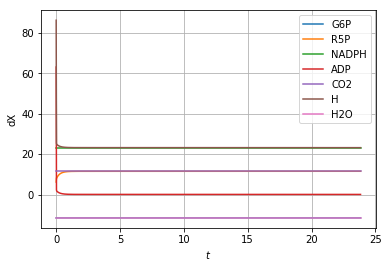

G6P:	-11.6 	-11.6	-1.0	-100.0%
R5P:	6.2 	11.5	1.0	99.4%
NADPH:	23.2 	23.2	2.0	200.0%
ADP:	63.1 	0.0	0.0	0.4%
CO2:	11.6 	11.6	1.0	100.0%
H:	86.3 	23.2	2.0	200.4%
H2O:	-11.6 	-11.6	-1.0	-100.0%

 Path = R5P


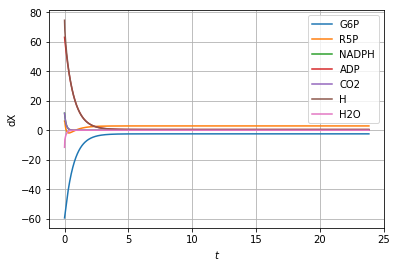

G6P:	-59.5 	-2.4	-5.0	-100.0%
R5P:	6.2 	2.9	6.0	120.0%
NADPH:	11.6 	0.0	0.0	0.2%
ADP:	63.1 	0.5	1.0	20.0%
CO2:	11.6 	0.0	0.0	0.1%
H:	74.7 	0.5	1.0	20.2%
H2O:	-11.6 	-0.0	-0.0	-0.1%

 Path = NADPH


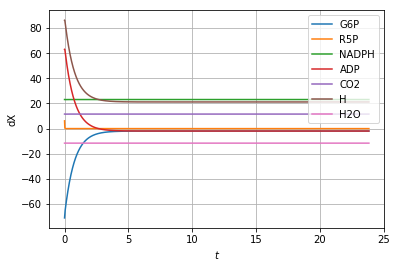

G6P:	-71.1 	-1.9	-1.0	-100.0%
R5P:	6.2 	0.0	0.0	0.0%
NADPH:	23.2 	23.1	12.0	1200.0%
ADP:	63.1 	-1.9	-1.0	-100.0%
CO2:	11.6 	11.6	6.0	600.0%
H:	86.3 	21.2	11.0	1100.0%
H2O:	-11.6 	-11.6	-6.0	-600.0%


In [24]:
approximateFlowstats = True

Spec = ['G6P','R5P','NADPH','ADP','CO2','H','H2O']
paths = ['all','both','R5P','NADPH']
#paths = ['R5P']
RATIO = {}
for path in paths:
    Ratio = {}
    normalisedRatio = {}
 
    ## Set up pathway]
    spec = sc['species']
    sc,sf,dX_G6P_0 = setPath(s,path=path)
    
    ## Set up parameters
    par = copy.copy(parameter)
    if approximateFlowstats:
        small = 1e-3
        par = copy.copy(parameter)
        for fs in sf['flowstats']:
            par['kappa_'+fs] = small
        sf = None
        
    ## Simulate
    t = np.linspace(0,3*t_0,1000)
    
#     ## Find steady-state with no flowstats 
#     dat_ss = st.sim(s,sc=sc,sf=sf,t=t,parameter=parameter,X0=conc)
#     X_ss = dat_ss['X'][-1,:]
    
    dat = st.sim(s,sc=sc,sf=sf,t=t,parameter=par,X0=conc)
    #st.plot(s,dat,species=[])
    st.plot(s,dat,reaction=[],species=Spec,dX=True)
    
    ## Extract some external flows
    DX = dat['dX']
    dX = {}
    for Sp in Spec:
        dX[Sp] = DX[:,spec.index(Sp)]
        Ratio[Sp] = -dX[Sp]/dX['G6P']
        normalisedRatio[Sp] =  -dX_G6P_0*dX[Sp]/dX['G6P'] 
        
    RATIO[path] = normalisedRatio
    
    ## Print steady-state values
    for Sp in Spec:
        ratio = Ratio[Sp][-1]
        print(f'{Sp}:\t{dX[Sp][0]:3.1f} \t{dX[Sp][-1]:3.1f}\t{(dX_G6P_0*ratio):3.1f}\t{100*ratio:3.1f}%')
    

(0, 8)

Text(0,0.5,'$\\rho_{R5P}$')

Text(0.5,0,'$t/t_0$')

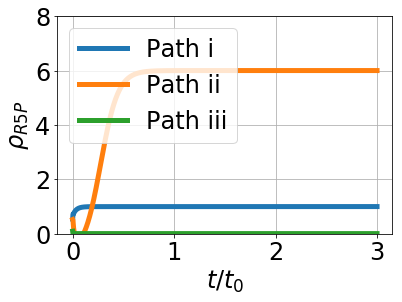

(0, 15)

Text(0,0.5,'$\\rho_{NADPH}$')

Text(0.5,0,'$t/t_0$')

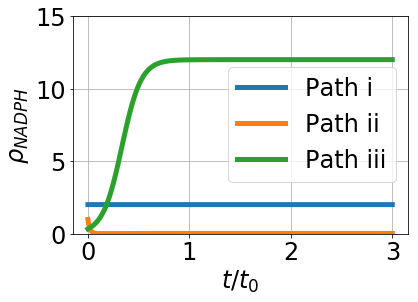

In [25]:
## Plot ratios
name = ['i','ii','iii']
for sp in ['R5P','NADPH']: 
    BigFont = 24
    plt.rcParams.update({'font.size': BigFont})
    for i,path in enumerate(['both','R5P','NADPH']):
        Ratio = RATIO[path]
        label = f'Path {name[i]}'
        plt.plot(t/t_0,Ratio[sp],label=label,linewidth=5)
    if sp=='R5P':
        ylim = 8
    else:
        ylim=15
    plt.ylim((0,ylim))
    ylabel = r'$\rho_{'+sp+'}$'
    plt.ylabel(ylabel)
    plt.xlabel('$t/t_0$')
    plt.legend()
    plt.grid()
    if SaveFig:
        plt.savefig(f'Figs/{sp}.pdf',bbox_inches='tight')

    plt.show()

In [26]:
X = np.array([1,2,3])
print(X)
print(X.T)
print(np.outer(X,X))
print(np.linalg.pinv(np.outer(X,X)))
print(np.linalg.pinv(np.outer(X,X))@X.T)
print(X@X.T)

[1 2 3]
[1 2 3]
[[1 2 3]
 [2 4 6]
 [3 6 9]]
[[0.00510204 0.01020408 0.01530612]
 [0.01020408 0.02040816 0.03061224]
 [0.01530612 0.03061224 0.04591837]]
[0.07142857 0.14285714 0.21428571]
14


# Michaelis-Menten formulation
## Show results

In [27]:
for reac in reaction:
    MMpar = MMparameter[reac]
    f_max = MMpar['f_max']
    rho = MMpar['rho']
    k_v = MMpar['k_v']
    print(f'Reaction {reac}:')
    print(f'f_max = {f_max:6.2f}; rho = {rho:1.2f}; k_v = {k_v:4.2f}')
    kappa,K_CE = MMtoBG(MMpar,K_E=K_E)
    print(f'kappa_1 = {kappa[0]:3.1f}; kappa_2 = {kappa[1]:3.1f}; K_C = {K_CE[0]:3.1f}; K_E = {K_CE[1]:3.1f}')
    

Reaction PGI:
f_max = 132.87; rho = 0.20; k_v = 0.10
kappa_1 = 664.4; kappa_2 = 166.1; K_C = 1.0; K_E = 10.0
Reaction PFK:
f_max =  61.18; rho = 0.20; k_v = 0.10
kappa_1 = 305.9; kappa_2 = 76.5; K_C = 1.0; K_E = 10.0
Reaction FBA:
f_max = 123.18; rho = 0.20; k_v = 0.10
kappa_1 = 615.9; kappa_2 = 154.0; K_C = 1.0; K_E = 10.0
Reaction TPI:
f_max = 267.28; rho = 0.20; k_v = 0.10
kappa_1 = 1336.4; kappa_2 = 334.1; K_C = 1.0; K_E = 10.0
Reaction GND:
f_max =   9.55; rho = 0.20; k_v = 0.10
kappa_1 = 47.8; kappa_2 = 11.9; K_C = 1.0; K_E = 10.0
Reaction RPI:
f_max = 5570.71; rho = 0.20; k_v = 0.10
kappa_1 = 27853.5; kappa_2 = 6963.4; K_C = 1.0; K_E = 10.0
Reaction TKT2:
f_max =   4.48; rho = 0.20; k_v = 0.10
kappa_1 = 22.4; kappa_2 = 5.6; K_C = 1.0; K_E = 10.0
Reaction TKT1:
f_max =  13.32; rho = 0.20; k_v = 0.10
kappa_1 = 66.6; kappa_2 = 16.7; K_C = 1.0; K_E = 10.0
Reaction RPE:
f_max = 126.53; rho = 0.20; k_v = 0.10
kappa_1 = 632.7; kappa_2 = 158.2; K_C = 1.0; K_E = 10.0


## Bond graph model of Enzyme Catalysed Reaction (RE)

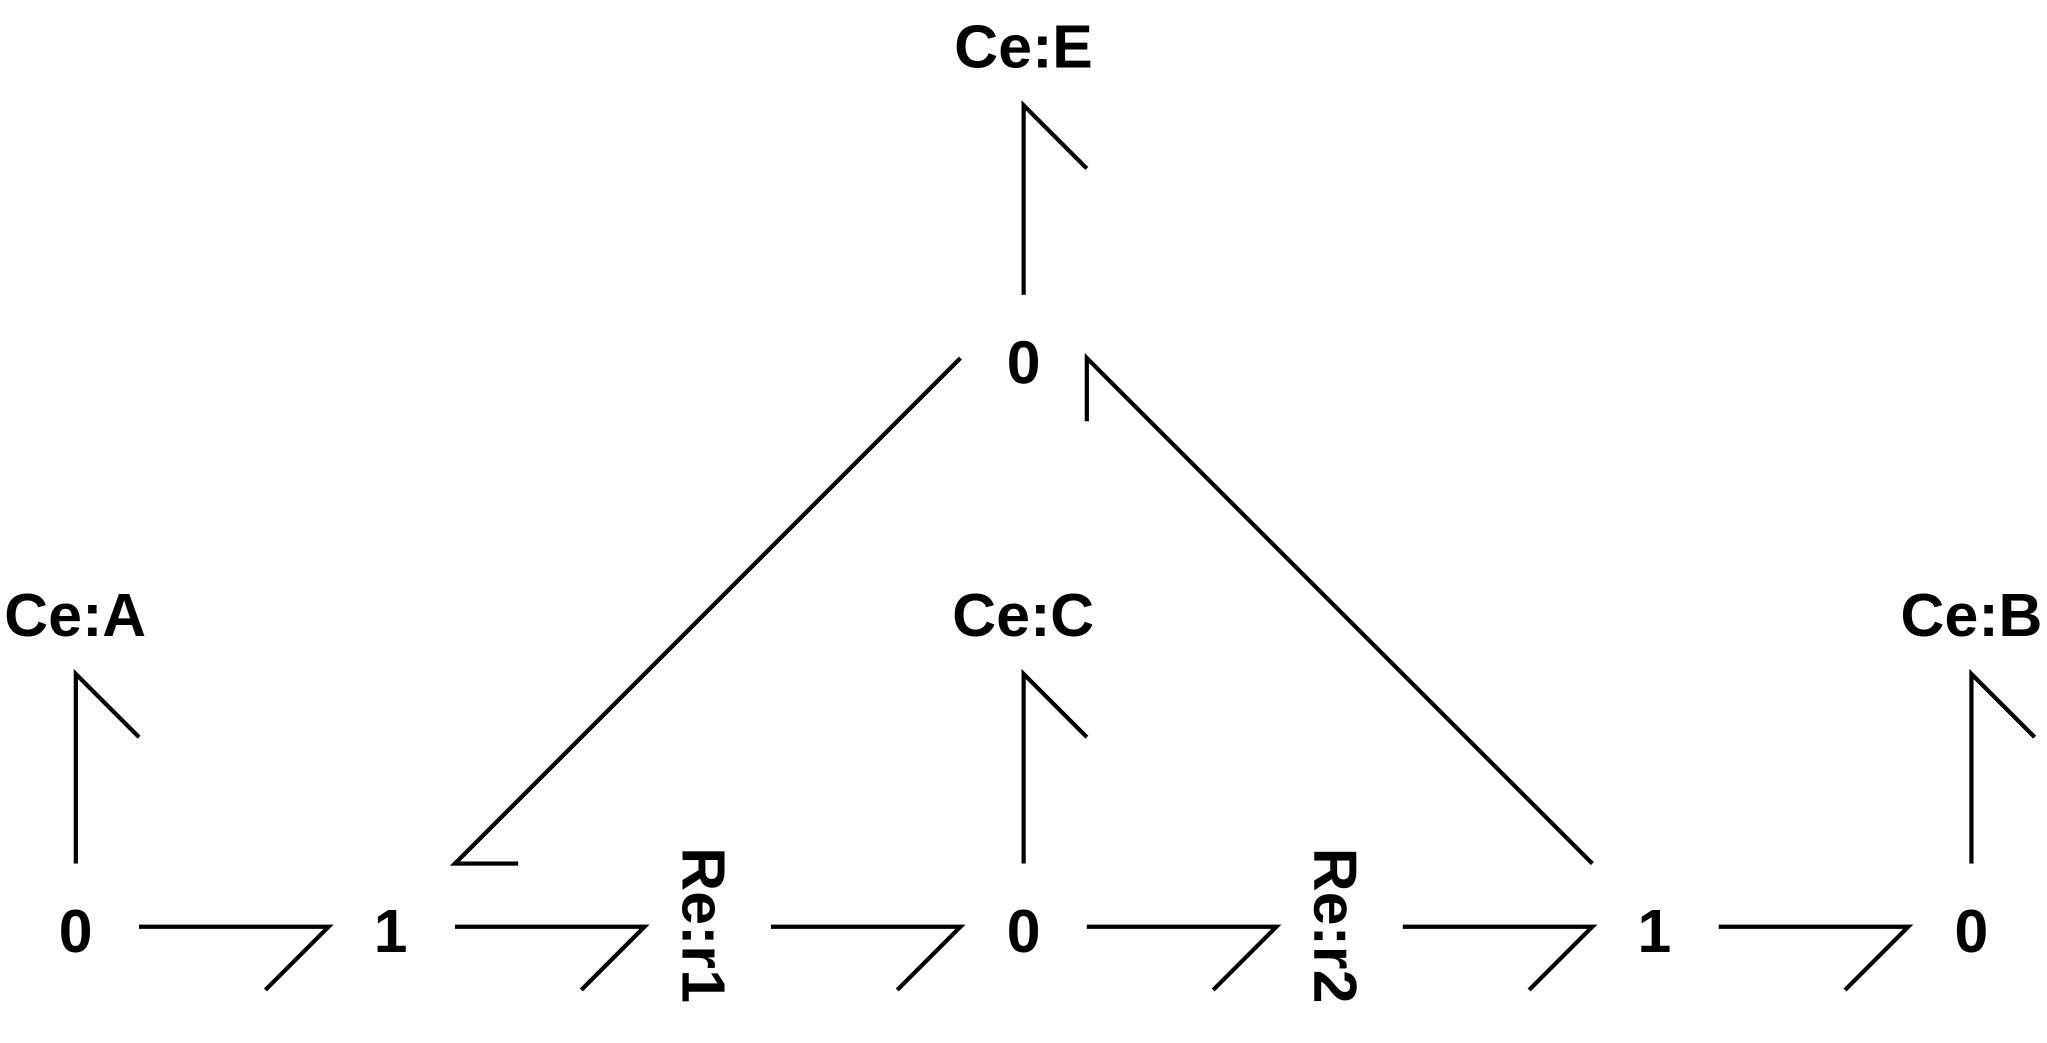

In [28]:
sbg.model('RE_abg.svg')
import RE_abg as RE
disp.SVG('RE_abg.svg')

In [29]:
sRE = st.stoich(RE.model(),quiet=quiet)
disp.Latex(st.sprintrl(sRE,chemformula=True))

<IPython.core.display.Latex object>

In [30]:
stbg.model(s,filename='PPP_abg')
import PPP_abg
PPP = PPP_abg.model()
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

## Replace Re components by RE

In [31]:
imp.reload(mbg)
mbg.ReRE(PPP,quiet=quiet)

<module 'modularBondGraph' from '/home/peterg/WORK/Research/SystemsBiology/lib/python/modularBondGraph.py'>

In [32]:
sPPPRE = st.stoich(PPP,quiet=quiet)

In [33]:
disp.Latex(st.sprintrl(sPPPRE,chemformula=True))

<IPython.core.display.Latex object>

In [34]:
print(chemostats)

['ADP', 'ATP', 'CO2', 'G3P', 'G6P', 'H', 'H2O', 'NADP', 'NADPH', 'R5P']


In [35]:
scPPPRE = st.statify(sPPPRE,chemostats=chemostats)

## Set up parameters

In [36]:
parameter = {}
for i,spec in enumerate(s['species']):
    parameter['K_'+spec] = K_spec[i]
    
for reac in reaction:
    MMpar = MMparameter[reac]
    kappa,K_CE = MMtoBG(MMpar,K_E=100.0)
    for i in ['1','2']:
        Kappa = f'kappa_{reac}{i}'
        parameter[Kappa] = kappa[int(i)-1]
    for i,spec in enumerate(['cmp','ase']):
        K = f'K_{reac}{spec}'
        parameter[K] = K_CE[i]
        
# print(parameter)        

In [37]:
## Initial conds
n_X = sPPPRE['n_X']
X0 = 0.5*np.ones(n_X)
for i,spec in enumerate(sPPPRE['species']):
    if spec in s['species']:
        X0[i] = conc[s['species'].index(spec)]

## Simulate

In [38]:
approximateFlowstats = True

Spec = ['G6P','R5P','NADPH','ADP','CO2','H','H2O']
paths = ['all','both','R5P','NADPH']
#paths = ['R5P']
RATIO = {}
for path in paths:
    Ratio = {}
    normalisedRatio = {}
 
    ## Set up pathway]
    spec = sPPPRE['species']
    sc,sf,dX_G6P_0 = setPath(sPPPRE,path=path)
    
    ## Set up parameters
    par = copy.copy(parameter)
    if approximateFlowstats:
        small = 1e-3
        par = copy.copy(parameter)
        for fs in sf['flowstats']:
            par['kappa_'+fs+'1'] = small
            par['kappa_'+fs+'2'] = small
        sf = None
        
    ## Find the initial condion X_ss after the initial transient due to E/C
    t_ss = np.linspace(0,t_0/100,100)
    dat_ss = st.sim(sPPPRE,sc=sc,t=t_ss,parameter=parameter,X0=X0)
    X_ss = dat_ss['X'][-1,:]
    
    ## Simulate from after transient
    dat = st.sim(sPPPRE,sc=sc,t=t,parameter=par,X0=X_ss)
#     st.plot(s,dat,reaction=[],species=Spec,dX=True)
    
    ## Extract some external flows
    DX = dat['dX']
    dX = {}
    for Sp in Spec:
        dX[Sp] = DX[:,spec.index(Sp)]
        Ratio[Sp] = -dX[Sp]/dX['G6P']
        normalisedRatio[Sp] =  -dX_G6P_0*dX[Sp]/dX['G6P'] 
        
    RATIO[path] = normalisedRatio
    
    ## Print steady-state values
    for Sp in Spec:
        ratio = Ratio[Sp][-1]
        print(f'{Sp}:\t{dX[Sp][0]:3.1f} \t{dX[Sp][-1]:3.1f}\t{(dX_G6P_0*ratio):3.1f}\t{100*ratio:3.1f}%')
    


 Path = all
G6P:	-63.8 	-62.5	-10.0	-100.0%
R5P:	0.8 	-0.7	-0.1	-1.0%
NADPH:	2.3 	1.0	0.2	1.6%
ADP:	62.8 	62.8	10.0	100.4%
CO2:	1.8 	0.5	0.1	0.8%
H:	63.7 	63.7	10.2	102.0%
H2O:	-0.1 	-0.5	-0.1	-0.8%

 Path = both
Flowstat PGI is not a model reaction
Flowstat TKT2 is not a model reaction
G6P:	-0.7 	-0.5	-1.0	-100.0%
R5P:	1.5 	0.5	0.9	92.9%
NADPH:	2.3 	1.0	2.0	197.1%
ADP:	53.3 	0.0	0.0	4.7%
CO2:	1.8 	0.5	1.0	98.2%
H:	54.2 	1.0	2.0	201.8%
H2O:	-0.1 	-0.5	-1.0	-98.3%

 Path = R5P
Flowstat G6PDH2R is not a model reaction
G6P:	-55.7 	-0.4	-5.0	-100.0%
R5P:	1.5 	0.4	6.0	119.9%
NADPH:	1.8 	0.0	0.0	0.3%
ADP:	53.3 	0.1	1.0	20.0%
CO2:	1.8 	0.0	0.0	0.2%
H:	53.8 	0.1	1.0	20.3%
H2O:	-0.1 	-0.0	-0.0	-0.2%

 Path = NADPH
G6P:	-56.9 	-0.1	-1.0	-100.0%
R5P:	0.1 	0.0	0.0	0.0%
NADPH:	3.7 	1.0	11.6	1155.1%
ADP:	53.2 	-0.1	-1.0	-95.7%
CO2:	3.3 	0.5	5.8	575.7%
H:	54.2 	0.9	10.6	1059.4%
H2O:	-0.1 	-0.5	-5.8	-576.2%


## Plot ratios

Text(0,0.5,'$\\rho_{R5P}$')

Text(0.5,0,'$t/t_0$')

(0, 8)

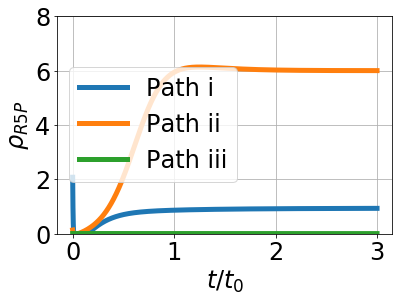

Text(0,0.5,'$\\rho_{NADPH}$')

Text(0.5,0,'$t/t_0$')

(0, 15)

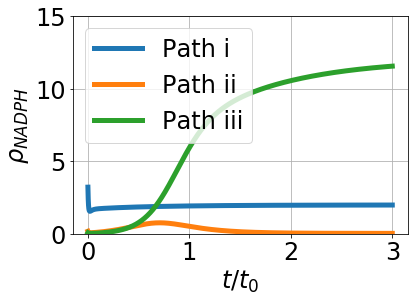

In [39]:
## Plot ratios
name = ['i','ii','iii']
for sp in ['R5P','NADPH']: 
    BigFont = 24
    plt.rcParams.update({'font.size': BigFont})
    for i,path in enumerate(['both','R5P','NADPH']):
        Ratio = RATIO[path]
        label = f'Path {name[i]}'
        plt.plot(t/t_0,Ratio[sp],label=label,linewidth=5)
    ylabel = r'$\rho_{'+sp+'}$'
    plt.ylabel(ylabel)
    plt.xlabel('$t/t_0$')
    plt.legend()
    plt.grid()
    if sp=='R5P':
        ylim = 8
    else:
        ylim=15
    plt.ylim((0,ylim))
    
    if SaveFig:
        plt.savefig(f'Figs/{sp}_MM.pdf',bbox_inches='tight')

    plt.show()

In [40]:
## Compare concentrations
conc_mam = Concentration['Mammalian']
conc_eco = Concentration['Ecoli']
for spec in conc_eco.keys():
    ratio = conc_eco[spec]/conc_mam[spec]
    print(f'{spec}: {ratio:2.2e}')

6PGC: 2.28e+02
ADP: 9.75e-01
ATP: 2.06e+00
CO2: 9.86e-03
DHAP: 1.88e+00
E4P: 4.76e+00
F6P: 2.60e+01
FDP: 1.00e+01
G3P: 1.92e+00
G6P: 1.17e+01
NADP: 7.32e-02
NADPH: 1.85e+00
R5P: 2.77e+01
RU5PD: 2.13e+01
S7P: 4.87e+01
XU5PD: 6.05e+00
